# BLIP: Bootstrapping Language-Image Pre-training

## References
https://github.com/salesforce/BLIP

 * Copyright (c) 2022, salesforce.com, inc.
 * All rights reserved.
 * SPDX-License-Identifier: BSD-3-Clause
 * For full license text, see LICENSE.txt file in the repo root or https://opensource.org/licenses/BSD-3-Clause
 * By Junnan Li



In [23]:
#| default_exp image.blip

In [24]:
#| hide
%load_ext autoreload
%autoreload 2
from nbdev.showdoc import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Imports

In [25]:
#| export


import warnings
warnings.filterwarnings("ignore")

from nimrod.utils import get_device
from nimrod.image.vit import VisionTransformer, interpolate_pos_embed
from nimrod.image.med import BertConfig, BertModel, BertLMHeadModel
from transformers import BertTokenizer

import torch
from torch import nn
import torch.nn.functional as F
from torchvision import transforms
from torchvision.transforms.functional import InterpolationMode


import os
from urllib.parse import urlparse
from timm.models.hub import download_cached_file

from PIL import Image
import requests
from transformers import BlipProcessor, BlipForConditionalGeneration

## Base

In [26]:
#| export

MED_CFG = "../config/data/image/med_config.json"

class BLIP_Base(nn.Module):
    def __init__(self,                 
                 med_config = MED_CFG,  
                 image_size = 224,
                 vit = 'base',
                 vit_grad_ckpt = False,
                 vit_ckpt_layer = 0,                 
                 ):
        """
        Args:
            med_config (str): path for the mixture of encoder-decoder model's configuration file
            image_size (int): input image size
            vit (str): model size of vision transformer
        """               
        super().__init__()
        
        self.visual_encoder, vision_width = create_vit(vit,image_size, vit_grad_ckpt, vit_ckpt_layer)
        self.tokenizer = init_tokenizer()   
        med_config = BertConfig.from_json_file(med_config)
        med_config.encoder_width = vision_width
        self.text_encoder = BertModel(config=med_config, add_pooling_layer=False)  

        
    def forward(self, image, caption, mode):
        
        assert mode in ['image', 'text', 'multimodal'], "mode parameter must be image, text, or multimodal"
        text = self.tokenizer(caption, return_tensors="pt").to(image.device) 
        
        if mode=='image':    
            # return image features
            image_embeds = self.visual_encoder(image)             
            return image_embeds
        
        elif mode=='text':
            # return text features
            text_output = self.text_encoder(text.input_ids, attention_mask = text.attention_mask,                      
                                            return_dict = True, mode = 'text')  
            return text_output.last_hidden_state
        
        elif mode=='multimodal':
            # return multimodel features
            image_embeds = self.visual_encoder(image)    
            image_atts = torch.ones(image_embeds.size()[:-1],dtype=torch.long).to(image.device)      
            
            text.input_ids[:,0] = self.tokenizer.enc_token_id
            output = self.text_encoder(text.input_ids,
                                       attention_mask = text.attention_mask,
                                       encoder_hidden_states = image_embeds,
                                       encoder_attention_mask = image_atts,      
                                       return_dict = True,
                                      )              
            return output.last_hidden_state
        


## Decoder

In [27]:
#| export
        
class BLIP_Decoder(nn.Module):
    def __init__(self,                 
                 med_config = MED_CFG,  
                 image_size = 384,
                 vit = 'base',
                 vit_grad_ckpt = False,
                 vit_ckpt_layer = 0,
                 prompt = 'a picture of ',
                 ):
        """
        Args:
            med_config (str): path for the mixture of encoder-decoder model's configuration file
            image_size (int): input image size
            vit (str): model size of vision transformer
        """            
        super().__init__()
        
        self.visual_encoder, vision_width = create_vit(vit,image_size, vit_grad_ckpt, vit_ckpt_layer)
        self.tokenizer = init_tokenizer()   
        med_config = BertConfig.from_json_file(med_config)
        med_config.encoder_width = vision_width
        self.text_decoder = BertLMHeadModel(config=med_config)    
        
        self.prompt = prompt
        self.prompt_length = len(self.tokenizer(self.prompt).input_ids)-1

        
    def forward(self, image, caption):
        
        image_embeds = self.visual_encoder(image) 
        image_atts = torch.ones(image_embeds.size()[:-1],dtype=torch.long).to(image.device)
        
        text = self.tokenizer(caption, padding='longest', truncation=True, max_length=40, return_tensors="pt").to(image.device) 
        
        text.input_ids[:,0] = self.tokenizer.bos_token_id
        
        decoder_targets = text.input_ids.masked_fill(text.input_ids == self.tokenizer.pad_token_id, -100)         
        decoder_targets[:,:self.prompt_length] = -100
     
        decoder_output = self.text_decoder(text.input_ids, 
                                           attention_mask = text.attention_mask, 
                                           encoder_hidden_states = image_embeds,
                                           encoder_attention_mask = image_atts,                  
                                           labels = decoder_targets,
                                           return_dict = True,   
                                          )   
        loss_lm = decoder_output.loss
        
        return loss_lm
        
    def generate(self, image, sample=False, num_beams=3, max_length=30, min_length=10, top_p=0.9, repetition_penalty=1.0):
        image_embeds = self.visual_encoder(image)

        if not sample:
            image_embeds = image_embeds.repeat_interleave(num_beams,dim=0)
            
        image_atts = torch.ones(image_embeds.size()[:-1],dtype=torch.long).to(image.device)
        model_kwargs = {"encoder_hidden_states": image_embeds, "encoder_attention_mask":image_atts}
        
        prompt = [self.prompt] * image.size(0)
        input_ids = self.tokenizer(prompt, return_tensors="pt").input_ids.to(image.device) 
        input_ids[:,0] = self.tokenizer.bos_token_id
        input_ids = input_ids[:, :-1] 

        if sample:
            #nucleus sampling
            outputs = self.text_decoder.generate(input_ids=input_ids,
                                                  max_length=max_length,
                                                  min_length=min_length,
                                                  do_sample=True,
                                                  top_p=top_p,
                                                  num_return_sequences=1,
                                                  eos_token_id=self.tokenizer.sep_token_id,
                                                  pad_token_id=self.tokenizer.pad_token_id, 
                                                  repetition_penalty=1.1,                                            
                                                  **model_kwargs)
        else:
            #beam search
            outputs = self.text_decoder.generate(input_ids=input_ids,
                                                  max_length=max_length,
                                                  min_length=min_length,
                                                  num_beams=num_beams,
                                                  eos_token_id=self.tokenizer.sep_token_id,
                                                  pad_token_id=self.tokenizer.pad_token_id,     
                                                  repetition_penalty=repetition_penalty,
                                                  **model_kwargs)            
            
        captions = []    
        for output in outputs:
            caption = self.tokenizer.decode(output, skip_special_tokens=True)    
            captions.append(caption[len(self.prompt):])
        return captions
    



## Helpers

In [28]:
#| export 

def blip_decoder(pretrained='',**kwargs):
    model = BLIP_Decoder(**kwargs)
    if pretrained:
        model,msg = load_checkpoint(model,pretrained)
        assert(len(msg.missing_keys)==0)
    return model    
    
def blip_feature_extractor(pretrained='',**kwargs):
    model = BLIP_Base(**kwargs)
    if pretrained:
        model,msg = load_checkpoint(model,pretrained)
        assert(len(msg.missing_keys)==0)
    return model        

def init_tokenizer():
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    tokenizer.add_special_tokens({'bos_token':'[DEC]'})
    tokenizer.add_special_tokens({'additional_special_tokens':['[ENC]']})       
    tokenizer.enc_token_id = tokenizer.additional_special_tokens_ids[0]  
    return tokenizer


def create_vit(vit, image_size, use_grad_checkpointing=False, ckpt_layer=0, drop_path_rate=0):
        
    assert vit in ['base', 'large'], "vit parameter must be base or large"
    if vit=='base':
        vision_width = 768
        visual_encoder = VisionTransformer(img_size=image_size, patch_size=16, embed_dim=vision_width, depth=12, 
                                           num_heads=12, use_grad_checkpointing=use_grad_checkpointing, ckpt_layer=ckpt_layer,
                                           drop_path_rate=0 or drop_path_rate
                                          )   
    elif vit=='large':
        vision_width = 1024
        visual_encoder = VisionTransformer(img_size=image_size, patch_size=16, embed_dim=vision_width, depth=24, 
                                           num_heads=16, use_grad_checkpointing=use_grad_checkpointing, ckpt_layer=ckpt_layer,
                                           drop_path_rate=0.1 or drop_path_rate
                                          )   
    return visual_encoder, vision_width

def is_url(url_or_filename):
    parsed = urlparse(url_or_filename)
    return parsed.scheme in ("http", "https")

def load_checkpoint(model,url_or_filename):
    if is_url(url_or_filename):
        cached_file = download_cached_file(url_or_filename, check_hash=False, progress=True)
        checkpoint = torch.load(cached_file, map_location='cpu') 
    elif os.path.isfile(url_or_filename):        
        checkpoint = torch.load(url_or_filename, map_location='cpu') 
    else:
        raise RuntimeError('checkpoint url or path is invalid')
        
    state_dict = checkpoint['model']
    
    state_dict['visual_encoder.pos_embed'] = interpolate_pos_embed(state_dict['visual_encoder.pos_embed'],model.visual_encoder) 
    if 'visual_encoder_m.pos_embed' in model.state_dict().keys():
        state_dict['visual_encoder_m.pos_embed'] = interpolate_pos_embed(state_dict['visual_encoder_m.pos_embed'],
                                                                         model.visual_encoder_m)    
    for key in model.state_dict().keys():
        if key in state_dict.keys():
            if state_dict[key].shape!=model.state_dict()[key].shape:
                del state_dict[key]
    
    msg = model.load_state_dict(state_dict,strict=False)
    print('load checkpoint from %s'%url_or_filename)  
    return model,msg
    

## Usage

In [29]:
device = get_device()
print("DEVICE: ", device)

def load_demo_image(image_size,device):
    img_url = 'https://storage.googleapis.com/sfr-vision-language-research/BLIP/demo.jpg' 
    raw_image = Image.open(requests.get(img_url, stream=True).raw).convert('RGB')   

    w,h = raw_image.size
    display(raw_image.resize((w//5,h//5)))
    
    transform = transforms.Compose([
        transforms.Resize((image_size,image_size),interpolation=InterpolationMode.BICUBIC),
        transforms.ToTensor(),
        transforms.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711))
        ]) 
    image = transform(raw_image).unsqueeze(0).to(device)   
    return image

DEVICE:  mps


In [30]:
# # from nimrod.image.blip import blip_decoder
# image_size = 384
# image = load_demo_image(image_size=image_size, device=device)

# model_url = 'https://storage.googleapis.com/sfr-vision-language-research/BLIP/models/model_base_capfilt_large.pth'
    
# model = blip_decoder(pretrained=model_url, image_size=image_size, vit='base')
# model.eval()
# model = model.to(device)

# with torch.no_grad():
#     # beam search
#     caption = model.generate(image, sample=False, num_beams=3, max_length=20, min_length=5) 
#     # nucleus sampling
#     # caption = model.generate(image, sample=True, top_p=0.9, max_length=20, min_length=5) 
#     print('caption: '+caption[0])

## HF Transformer version

In [31]:
processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")

In [32]:
# Load an image
# image = Image.open("path_to_your_image.jpg")
img_url = 'https://storage.googleapis.com/sfr-vision-language-research/BLIP/demo.jpg' 
image = Image.open(requests.get(img_url, stream=True).raw).convert('RGB')

# Conditional image captioning
text = "a photography of"
inputs = processor(image, text=text, return_tensors="pt")


In [ ]:
outputs = model.generate(**inputs)
caption = processor.decode(outputs[0], skip_special_tokens=True)
print("Generated Caption:", caption)
display(image)

In [21]:
# unConditional image captioning
inputs = processor(image, return_tensors="pt")

outputs = model.generate(**inputs)
caption = processor.decode(outputs[0], skip_special_tokens=True)
print("Generated Caption:", caption)

Generated Caption: a woman sitting on the beach with her dog


Generated Caption: a painting of a body of water in the middle of the ocean


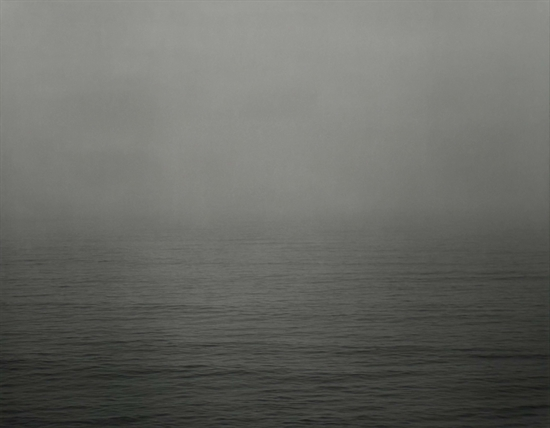

In [22]:
# Load an image
# image = Image.open("path_to_your_image.jpg")

# img_url = "https://images.artnet.com/aoa_lot_images/141282/shepard-fairey-kurt-cobain-endless-nameless-prints-and-multiples-zoom_374_500.jpg"
img_url = "https://images.artnet.com/aoa_lot_images/141287/hiroshi-sugimoto-gulf-of-bothnia-photographs.jpeg"
image = Image.open(requests.get(img_url, stream=True).raw).convert('RGB')

# Conditional image captioning
text = "a painting of"
inputs = processor(image, text=text, return_tensors="pt")
outputs = model.generate(**inputs)
caption = processor.decode(outputs[0], skip_special_tokens=True)
print("Generated Caption:", caption)
display(image)


In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()